# Making Models With Isambard
## Introduction
## Specifications available
A number of specifications (the term is borrowed from the field of architecture, where a specification is defined as "a detailed description of the design and materials used to make something") are currently available through Isambard. These include: alpha-helices, coiled-coil assemblies of different flavours, and simple DNA duplexes. To make a structure based on a specification, you need to know the parameters of that specification. We will demonstrate this with a simple alpha-helical coiled-coil dimer.

### Parameters required to make a coiled-coil dimer

![dimer_parameters](https://cloud.githubusercontent.com/assets/16082702/12421221/08613f3e-beb9-11e5-9bb0-652fd40e33c1.png)

To make a coiled-coil dimer, you need to know 

1. the number of residues on each helix, 
2. the radius of the assembly, 
3. the pitch of the assembly and 
4. the interface angle at which helices meet (Phi-C$\alpha$)



### Reading in a structure and identifying parameters
We will read a known coiled-coil dimer structure (CC-DI, PDB [4DZM.pdb](https://drive.google.com/open?id=0B2sZ5She4fA2QzdsUENNa2hmTE0)), into the AMPAL framework, and use tools within Isambard to calculate the parameters we need. The following code imports isambard so it is available to the ipython notebook, reads in the PDB file of interest and converts it into an AMPAL object. [N.B. This is a slightly modified form of 4DZM where we've converted iodo-phenylalanine to phenylalanine, and got rid of water molecules to make life a bit easier, so take the linked copy rather than downloading from another source.]

In [1]:
import isambard

my_cc = isambard.ampal.convert_pdb_to_ampal("4DZM.pdb")

my_cc

<Assembly (4DZM) containing 2 Polypeptides>

This has given us an Assembly object, which contains two Polypeptides in the AMPAL framework. We can access the sequences and each chain individually using the `.sequences` attribute. This returns a list, and you can access individual list elements as you would a regular python list.

In [2]:
my_cc.sequences

['GEIAALKQEIAALKKENAALKFEIAALKQGY', 'GEIAALKQEIAALKKENAALKFEIAALKQGY']

In [3]:
my_cc_a = my_cc[0]
my_cc_b = my_cc[1]

my_cc_a

<Polypeptide containing 31 Residues. Sequence: GEIAALKQEIAA...>

From the Polypeptide object, which is a special type of Polymer within the AMPAL framework, we can access the number of residues, and the chain identifier if needed. You can access the length of the chain either from the chain object itself, or from the length of the sequence.

In [4]:
len(my_cc_a.sequence)

31

In [5]:
len(my_cc_a)

31

In [6]:
my_cc_a.id

'A'

Before we extract parameters from the structure, we might want to know how 'good' the BUDE forcefield [BUFF] thinks the structure is, so that when we build a structure *de novo* we have something to compare it to. BUFF provides two scores, one for the interaction between Polypeptides in the Assembly, and one for the internal energy of the Assembly.

In [7]:
my_cc.buff_interaction_energy

<BUFF Score -127.68: 0.00 St | -107.09 De | -20.59 Ch>

In [8]:
my_cc.buff_internal_energy

<BUFF Score -899.78: 3.25 St | -468.80 De | -434.22 Ch>

### Measuring geometric parameters

In order to measure radius, pitch and Phi-C$\alpha$ of the assembly, we need to define a *__reference axis__*, that is the line that runs down the centre of the assembly. For a coiled-coil dimer, it runs between the two helices; for a barrel, this would be at the centre of the barrel, and is a list of points in 3D space. We will use this to calculate the other parameters. The reference axis is defined as a Primitive chain object populated with PseudoMonomers which represent the points in space of the axis.

In [9]:
reference_axis = isambard.analyse_protein.reference_axis_from_chains(my_cc)

In [10]:
reference_axis

<Primitive chain containing 31 PseudoMonomers>

#### Interface angles (Phi-C$\alpha$)

In Isambard, interface angles are accessed via the `analyse_protein.crick_angles` method, and are calculated for each residue in each helix individually.

In [11]:
crangles_a = isambard.analyse_protein.crick_angles(my_cc_a,reference_axis)
crangles_b = isambard.analyse_protein.crick_angles(my_cc_b,reference_axis)

In [12]:
crangles_a

[165.46311695313284,
 -73.7731235966416,
 26.54672679839078,
 128.47141485160603,
 -127.72847955562587,
 -29.230898305107225,
 75.77896871985133,
 179.13811106898652,
 -78.91543487166474,
 24.619715382288263,
 124.86576008079678,
 -132.1659822842109,
 -33.094770958544274,
 71.5612908445053,
 172.66909579579703,
 -87.21396295102991,
 17.62150247217829,
 122.41786905701451,
 -132.30491551944263,
 -25.580896174877395,
 77.39202166004726,
 178.68641715037646,
 -81.08703803043669,
 21.378411765253517,
 124.46637604063143,
 -137.48525842491375,
 -38.516041308102864,
 65.8051730938853,
 173.8634442139843,
 -69.52238541573473,
 None]

To get an average Phi-C$\alpha$ value, we take every seventh value from the list, and take the mean of this. To get the mean we need to use a module called `numpy`, which is *Numerical Python* and gives us access to lots of mathematical functions. In the following cell, we are going to use it to calculate mean Phi-C$\alpha$ values.

In [13]:
import numpy

phica_a_list = [crangles_a[x] for x in range(0,len(crangles_a),7) if crangles_a[x] is not None]
phica_b_list = [crangles_b[x] for x in range(0,len(crangles_b),7) if crangles_b[x] is not None]

phica_a = numpy.mean(phica_a_list)
phica_b = numpy.mean(phica_b_list)

phica_a, phica_b

(173.96403703645541, 173.96403703645541)

#### Radius
Radius is calculated by looking at successive distances from the centre of the $\alpha$ helix to the reference axis we calculated earlier. Again, this is calculated for each helix, and we take the mean value to use for model building.

In [14]:
radius_a_list = isambard.analyse_protein.polymer_to_reference_axis_distances(my_cc_a, reference_axis)
radius_b_list = isambard.analyse_protein.polymer_to_reference_axis_distances(my_cc_b, reference_axis)

radius = numpy.mean(radius_a_list+radius_b_list)

radius

5.12974619218142

#### Pitch
Pitch is calculated on a per-helix basis using alpha angles, which measures the tilt of a helix in a coiled-coil assembly wtith respect to the central reference axis that we already calculated. The radius of the helices is also required. For model building we take a mean value.

In [15]:
alpha_a_list = isambard.analyse_protein.alpha_angles(my_cc_a, reference_axis)
alpha_b_list = isambard.analyse_protein.alpha_angles(my_cc_b, reference_axis)

pitch_a_list = [(2* numpy.pi * radius) / numpy.tan(numpy.deg2rad(x)) for x in alpha_a_list if x is not None]
pitch_b_list = [(2* numpy.pi * radius) / numpy.tan(numpy.deg2rad(x)) for x in alpha_b_list if x is not None]

pitch = numpy.mean(pitch_a_list + pitch_b_list)

pitch

220.28472172509427

### Building a model
We now know all the parameters we need to rebuild this structure, and it can be done by generating a specification object from the CoiledCoil class. We will do this by 'subclassing', i.e. inheriting all the things we need from the general CoiledCoil class, and adding specific parameters for our case, into a class called `SimpleDimer2Phi`. 

In [16]:
class SimpleDimer2Phi(isambard.specifications.CoiledCoil):
    def __init__(self, aa, r, p, phica1,phica2,n=2):
        super().__init__(n, auto_build=False)
        self.aas = [aa]*n
        self.major_radii = [r]*n
        self.major_pitches = [p]*n
        self.phi_c_alphas = [phica1,phica2]
        self.orientations = [1]*n 
        self.build()

We can now make a model by calling the `SimpleDimer2Phi` class and filling in the parameters obtained earlier in the workbook. Enter these parameters in the cell below before pressing Ctrl+Enter to run it.

In [17]:
my_model = SimpleDimer2Phi(len(my_cc.sequences[0]), radius, pitch, phica_a, phica_b)
my_model.build()

Now write out this model to a PDB file for later reference.

In [18]:
with open('my_model.pdb','w') as outf:
    outf.write(my_model.pdb)

![my_model_bb](https://cloud.githubusercontent.com/assets/16082702/12421222/0861c33c-beb9-11e5-919d-67168da10135.png)

Hopefully your model looks something like the picture above. It has made a poly-alanine version of a coiled-coil helical dimer. Now we can model the sidechains using SCWRL4 (<i><a href="http://dunbrack.fccc.edu/scwrl4/index.php">G. G. Krivov, M. V. Shapovalov, and R. L. Dunbrack, Jr. Improved prediction of protein side-chain conformations with SCWRL4. Proteins (2009)</a></i>), output the PDB file for future reference. You should be able to see the sidechains as below.

In [19]:
sequences = my_cc.sequences
my_model.pack_new_sequences(sequences)
with open('my_model_sc.pdb','w') as outf:
    outf.write(my_model.pdb)

![my_model_sc](https://cloud.githubusercontent.com/assets/16082702/12421307/85a3b2f6-beb9-11e5-848a-cd43b081f2be.png)

Your model should look something like the picture above. Now we can score this model using BUFF, and also we can calculate an RMSD from this model to the original structure using ProFit (Martin, A.C.R., http://www.bioinf.org.uk/software/profit/).

In [20]:
my_model.buff_interaction_energy

<BUFF Score -110.44: 0.00 St | -100.38 De | -10.06 Ch>

In [21]:
rmsds,overlay = isambard.external_programs.run_profit(my_cc.pdb, my_model.pdb, return_pdb_string=True, align_type='all')

`rmsds` is the all-atom RMSDs calculated by ProFit.

In [22]:
rmsds

[2.173]

Write out the overlaid structure for future reference. 

In [23]:
with open('my_model_overlaid.pdb','w') as outf:
    outf.write(overlay)

![my_cc_my_model_overlay](https://cloud.githubusercontent.com/assets/16082702/12421220/0860a862-beb9-11e5-8682-13974df51711.png)

The overlay is a simple PDB string returned from ProFit. We can convert this back to an AMPAL object, write it out for viewing.

In [24]:
overlay_ampal = isambard.ampal.convert_pdb_to_ampal(overlay,path=False) ## convert overlay to AMPAL object

If you have a look closely at the asparagine pair at the middle of the dimeric structure (shown below), you'll see that the rotamers that SCWRL has picked for asparagine (right-hand side, dark blue) are more sensible than those in the original structure (left-hand side, cyan). The original 4DZM structure has multiple occupancies for the asparagine residues, and for simplicity we picked the first pair. The structure that SCWRL has returned has a hydrogen bond between the asparagine residues.

![asn_hbonds](https://cloud.githubusercontent.com/assets/16082702/12421660/29935b86-bebb-11e5-9746-9b9f6588113f.png)

### Tweaking the parameters
Try rebuilding the model again, this time changing the parameters as you like. What happens if you change the phi-C$\alpha$ values of one helix (or both)? Try varying the radius. Each time, score your model using BUFF and make a note of the RMSD to the original structure, and have a look at the models you produce on PyMOL.

### Going antiparallel
We are going to remake the coiled-coil dimer as an antiparallel structure. To do this, we need to modify the  `isambard.specifications.SimpleDimer2Phi` class, two extra parameters to specify firstly that the orientation of the second helix is antiparallel, and secondly, the z-shift, how far the helices can slide past one another. We'll make this using another subclass of CoiledCoil:

In [25]:
class SimpleDimer2PhiAP(isambard.specifications.CoiledCoil):
    def __init__(self, aa, r, p, phica1,phica2,zshift,n=2):
        super().__init__(n=2, auto_build=False)
        self.aas = [aa]*n
        self.major_radii = [r]*n
        self.major_pitches = [p]*n
        self.phi_c_alphas = [phica1,phica2]
        self.z_shifts = [0,zshift]
        self.orientations = [1,-1] 
        self.build()

In [26]:
my_ap_cc = SimpleDimer2PhiAP(len(my_cc.sequences[0]),radius,pitch,phica_a,phica_b,0.0)
my_ap_cc.build()
my_ap_cc.pack_new_sequences(my_cc.sequences)

Write the model out to PDB for future reference.

In [27]:
with open('my_ap_cc_model.pdb','w') as outf:
    
    outf.write(my_ap_cc.pdb)

Score the model using BUFF:

In [28]:
my_ap_cc.buff_interaction_energy

<BUFF Score -50.75: 26.81 St | -78.57 De | 1.02 Ch>

### Making it better - an introduction to optimisation 

It's not such a good score :-) (obviously?) We could improve this score by 'minimizing' the structure, i.e. trying to find new parameter for the sequence that improve the BUDE score. This is, in real life, a very bad idea, because we know that this sequence comes from a crystal structure of a parallel coiled-coil dimer, and it is highly unlikely ever to go antiparallel, but we are going to pretend that we can make it so, as a good exercise in learning how an optimiser works, and also to give you the heads up that although you can get an improved BUDE score through this process, if you make an unrealistic assumption at the beginning, BUFF and the optimiser will not help you out. 

We'll carry out this optimisation using an algorithm called <a href="https://en.wikipedia.org/wiki/Differential_evolution">**differential evolution**</a>. This is a metaheuristic, which means it makes no assumptions about the optimisation (this means it knows nothing about your parameters), and is able to search large spaces of candidate solutions (i.e. a large parameter space). It optimizes the parameters by keeping a population of candidate solutions (sets of model parameters) and creates new solutions (sets of parameters) by combining existing ones and then keeping whichever candidate has the best score.

The optimiser is actually quite easy to set up. You need to give it an isambard specification (in our case `SimpleDimer2Phi`) and an output path (which can be your home directory for the moment)

In [32]:
optimiser = isambard.optimisation.DE_Opt(SimpleDimer2PhiAP,output_path='./',run_id='test_antiparallel')

The next step is to give the optimiser the sequences to model, a set of parameter means and variances within which to sample. Again, you can see what the optimiser is expecting by using SHIFT+TAB inside the brackets of `optimiser.parameters`.

The order of the parameters inside the value means and value ranges must match the order required by `SimpleDimer2Phi`, which is `radius, pitch, phica1, phica2`. We will allow the radius to vary by up to 1  $\unicode{x212B}$ either side of 5 $\unicode{x212B}$, the pitch by 100 $^\circ$ and the Phi-C$\alpha$s by a full circle. We'll keep the z-shift to zero for this instance.

In [33]:
optimiser.parameters(my_ap_cc.sequences, [5.0,180,180,180], [1.0,100,180,180], 
                    [len(my_ap_cc.sequences[0]), 'var0','var1','var2','var3', 0])

Now, run it! You need to specify the size of each generation and the number of generations. We will use 20 models per generation and 30 generations.

gen	evals	avg     	std    	min     	max    
0  	20   	-55.7098	25.9688	-87.3202	36.1921
1  	20   	-66.6776	11.5237	-87.3202	-48.6604
2  	20   	-70.7497	12.2905	-92.6772	-50.6262
3  	20   	-73.9232	12.4769	-94.7884	-51.5833
4  	20   	-76.3185	12.6057	-94.7884	-51.5833
5  	20   	-79.9829	13.702 	-109.876	-51.5833
6  	20   	-83.0631	10.3908	-109.876	-55.4778
7  	20   	-88.5358	11.0805	-113.954	-70.5369
8  	20   	-90.3231	11.0024	-113.954	-70.5369
9  	20   	-93.2695	9.41309	-113.954	-78.7268
10 	20   	-94.4878	10.4496	-114.511	-78.7268
11 	20   	-96.4366	11.2302	-120.114	-79.2499
12 	20   	-101.157	13.0766	-131.298	-79.3819
13 	20   	-101.656	12.719 	-131.298	-79.3819
14 	20   	-101.809	12.622 	-131.298	-79.3819
15 	20   	-103.062	12.1646	-131.298	-79.3819
16 	20   	-104.63 	10.823 	-131.298	-88.7577
17 	20   	-107.587	11.3232	-131.298	-91.282 
18 	20   	-108.194	10.6796	-131.298	-95.1897
19 	20   	-109.572	11.0823	-131.298	-95.1897
20 	20   	-109.905	10.7501	-131.298	-95.1897
21 	20   	-1

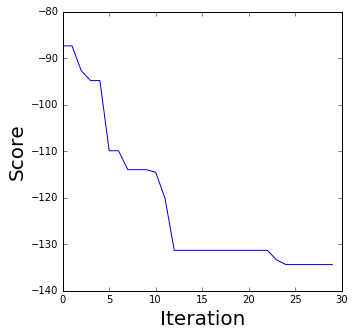

In [34]:
%matplotlib inline
optimiser.run_opt(20,30,1,plot=True,log=True)

The output above shows you the progress of the optimisation process, which is reproduced in a log file in the location we requested the output to be. Additionally the best model pdb file will be written to the same location. Open this up and have a look at the optimised model. What has the optimiser done to the model? 

There are different optimization methods available; have a look inside the optimisation directory for these.

### Making bigger things

Now you know how to subclass the CoiledCoil AMPAL specification object, see if you can make an alpha-helical barrel by increasing the value of `n`. Don't worry about what sequence to use initially, make some models and get comfortable with the parameters - for example try a few different radii, pitch and phi-c$\alpha$ values. As an aide, here are some parameters for the coiled-coil barrels in <a href="http://www.sciencemag.org/cgi/rapidpdf/346/6208/485?ijkey=ysj8Y4h7WOYgo&keytype=ref&siteid=sci">Thomson et. al. (Science 2014)</a>. Score the models you make using BUFF.


| Name | Oligo | Radius | Pitch | PhiC$\alpha$ | Sequence (g->f) |
|------|-------|--------|-------|--------------|----------|
|CC-Pent| 5    | 8.62   | 182.8 | 14.44|KIEQILQ |
|CC-Hex2| 6    | 9.48   | 131.7 | 18.22|EIAKSLK |
|CC-Hex3| 6    | 9.72   | 162.2 | 13.07|EIAQSIK |
|CC-Hept| 7    | 9.80   | 328.6 | 15.1 |EIAQALK |
